In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [0]:
# Path to the Delta table in DBFS
delta_table_path = "dbfs:/user/hive/warehouse/bank_additional_full"

# Read the Delta table into a DataFrame
df = spark.read.format("delta").load(delta_table_path)

# Show the first few rows of the DataFrame in a tabular format
display(df.limit(5))

age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
26,admin.,single,high.school,no,no,no,cellular,apr,mon,123,3,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,no
40,blue-collar,married,basic.6y,no,no,no,cellular,apr,mon,97,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,no
46,entrepreneur,married,unknown,no,yes,yes,cellular,apr,mon,207,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,no
32,student,single,university.degree,no,yes,no,cellular,apr,mon,712,4,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,yes
59,self-employed,married,professional.course,no,yes,no,cellular,apr,mon,274,5,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,no


o Clean the dataset


In [0]:
# Assuming you have a DataFrame named 'df' with original column names
original_columns = df.columns

# Rename columns by replacing dots with underscores
new_columns = [col.replace('.', '_') for col in original_columns]
df = df.toDF(*new_columns)

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean as _mean, stddev as _stddev, count, isnan, isnull

# Define the column names from column list
numeric_columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
target_column_name = 'y'

for column in categorical_columns:
    df = df.withColumn(column, when(col(column) == 'unknown', None).otherwise(col(column)))

Data Understanding
- Draw a sample of the data
- Apply some in pySpark available methods to describe the data
- Convert the sample into a pandas DataFrame and run some typical data
understanding steps

In [0]:
# 1. Draw a sample of the data
sample_df = df.sample(False, 0.1, seed=42)  # Adjust the sampling fraction as needed

# 2. Describe the data using PySpark
# Describe the data using PySpark
summary = sample_df.describe()

# Convert the PySpark DataFrame to a Pandas DataFrame
summary_pd = summary.toPandas()

summary_pd

,summary,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,count,4127,4092,4120,3958,3280,4036,4036,4127,4127,4127,4127,4127,4127,4127,4127,4127,4127,4127,4127,4127,4127
1,mean,40.216622243760604,None,None,None,None,None,None,None,None,None,260.74751635570635,2.5645747516355706,960.4899442694451,0.1747031742185607,None,0.06253937484859286,93.58361788223932,-40.476593166950366,3.6047230433729363,5165.584492367257,None
2,stddev,10.528938260359851,None,None,None,None,None,None,None,None,None,257.0237398346599,2.8121223645300257,191.77874135484572,0.5146988755322555,None,1.5708512275503221,0.5840201471966092,4.616762197635067,1.7392649852477953,72.48532471780645,None
3,min,17,admin.,divorced,basic.4y,no,no,no,cellular,apr,fri,5,1,0,0,failure,-3.4,92.201,-50.8,0.634,4963.6,no
4,max,95,unemployed,single,university.degree,yes,yes,yes,telephone,sep,wed,3183,56,999,6,success,1.4,94.767,-26.9,5.045,5228.1,yes


First 5 rows of the Pandas DataFrame:
   age          job  marital  ... euribor3m nr_employed   y
0   41  blue-collar  married  ...     4.857      5191.0  no
1   35  blue-collar  married  ...     4.857      5191.0  no
2   50  blue-collar  married  ...     4.857      5191.0  no
3   54       admin.  married  ...     4.857      5191.0  no
4   55   unemployed  married  ...     4.857      5191.0  no

[5 rows x 21 columns]

Summary Statistics:
               age     duration  ...    euribor3m  nr_employed
count  4127.000000  4127.000000  ...  4127.000000  4127.000000
mean     40.216622   260.747516  ...     3.604723  5165.584492
std      10.528938   257.023740  ...     1.739265    72.485325
min      17.000000     5.000000  ...     0.634000  4963.600000
25%      32.000000   101.000000  ...     1.334000  5099.100000
50%      38.000000   179.000000  ...     4.857000  5191.000000
75%      47.000000   326.500000  ...     4.961000  5228.100000
max      95.000000  3183.000000  ...     5.045000  522

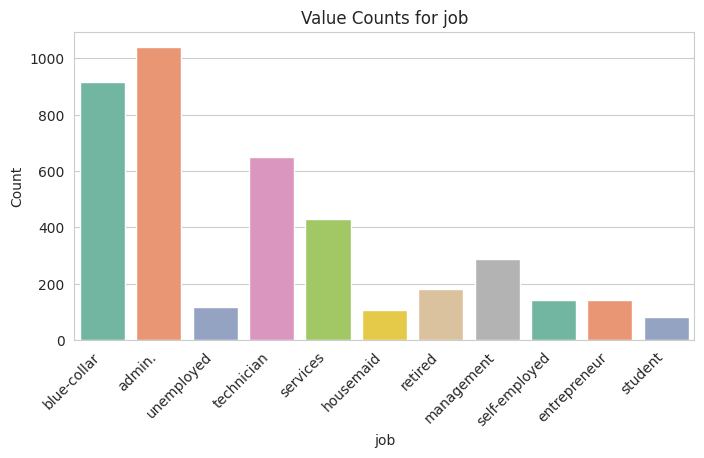

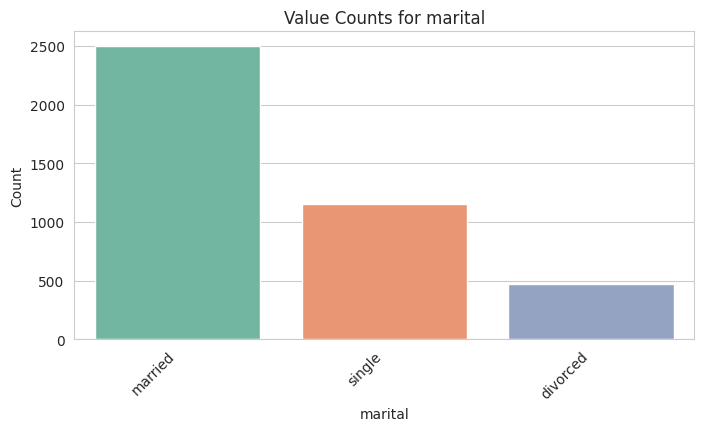

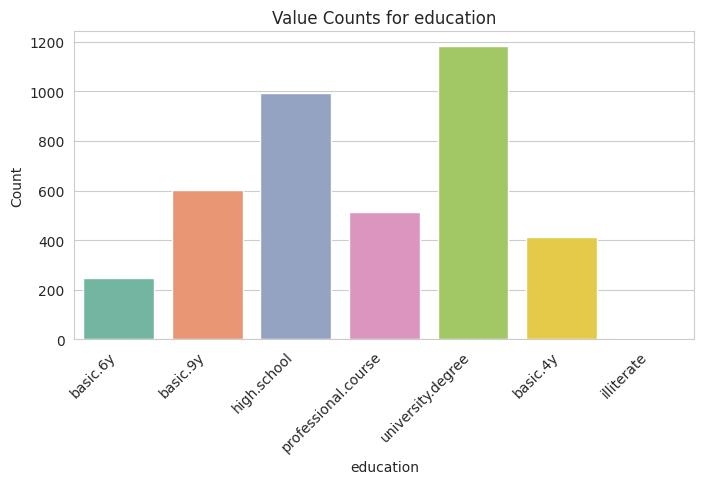

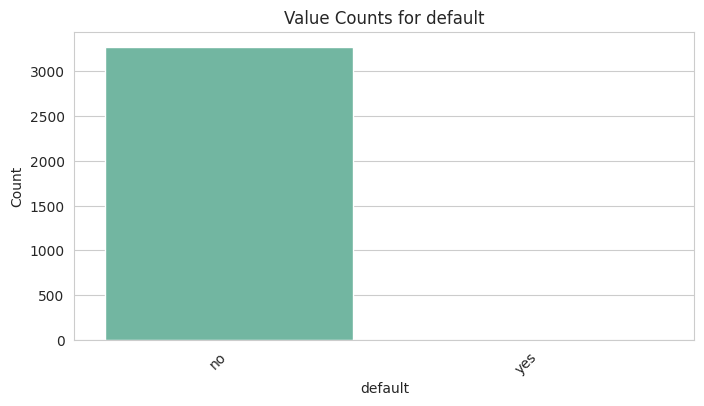

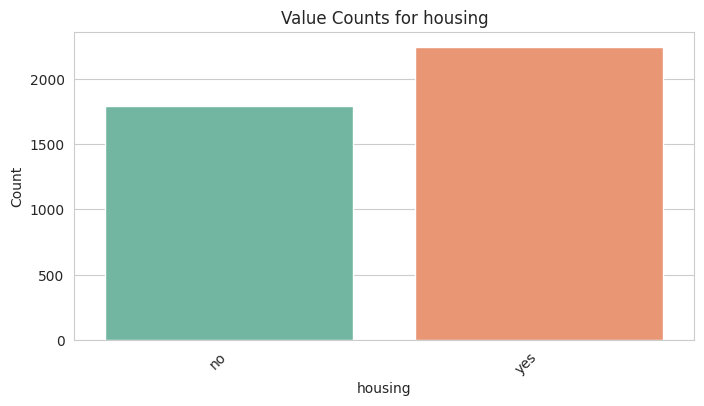

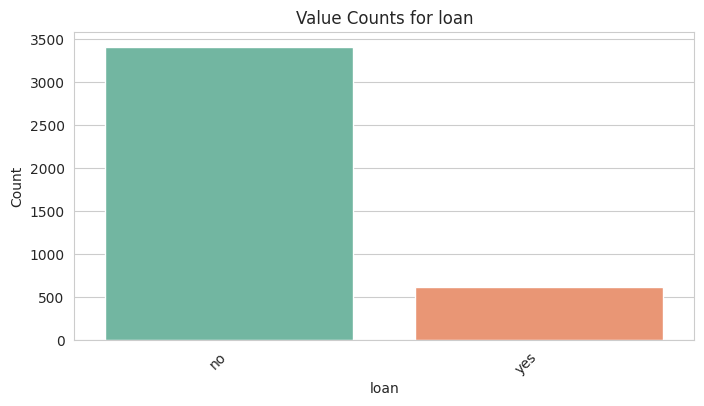

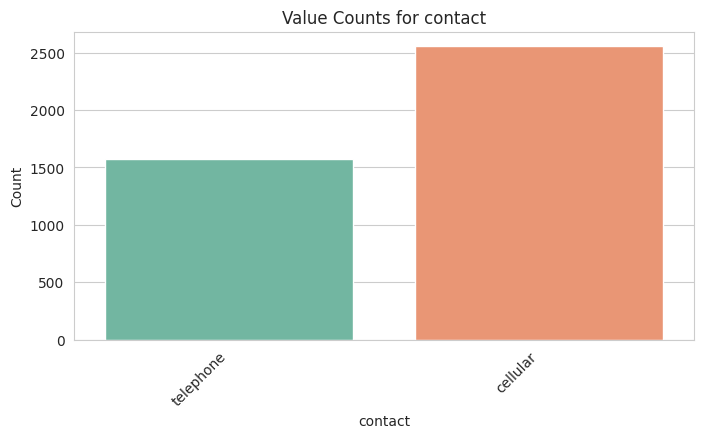

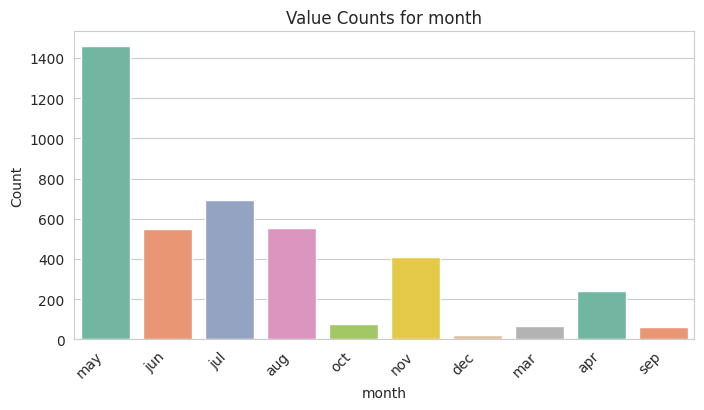

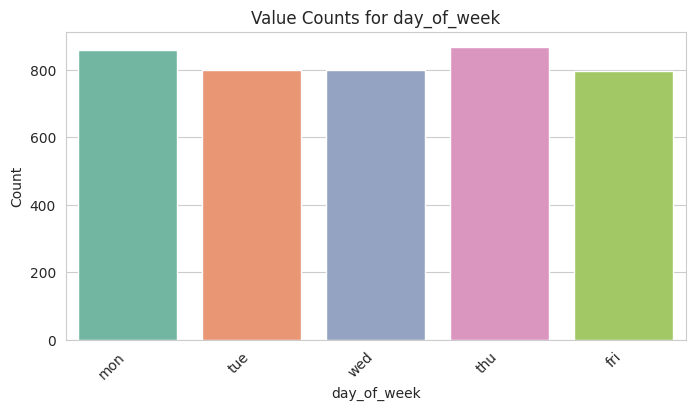

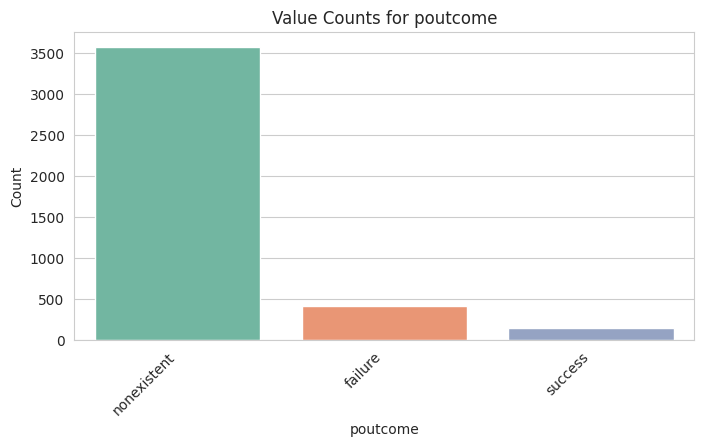

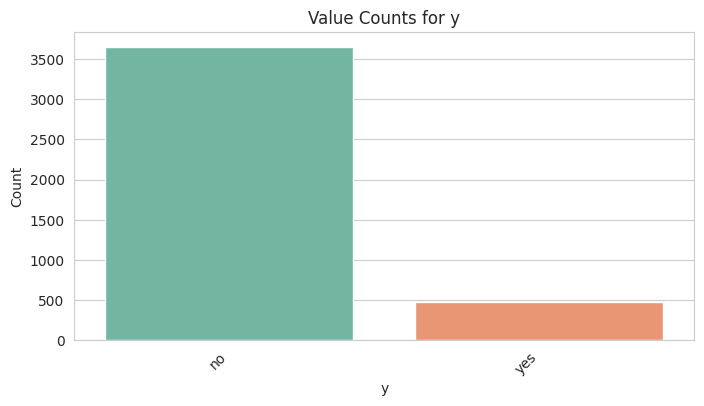

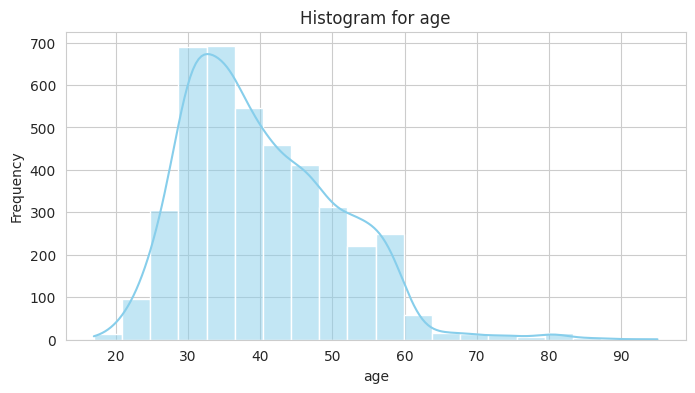

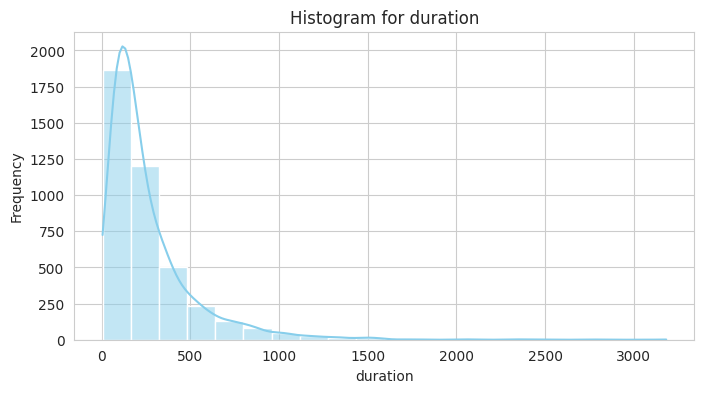

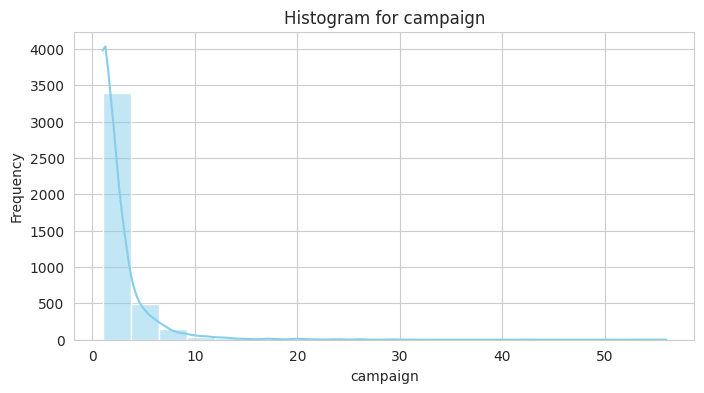

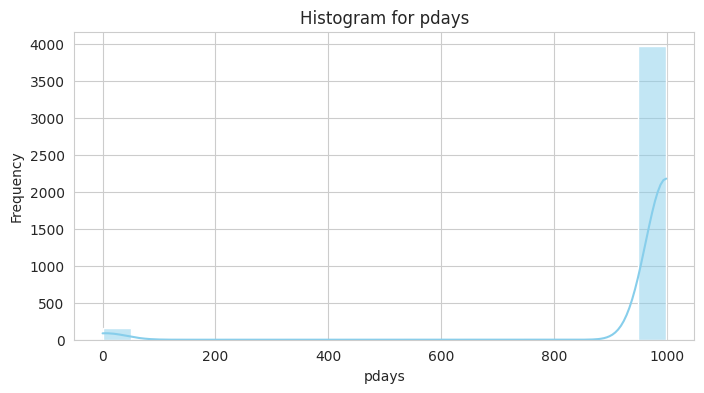

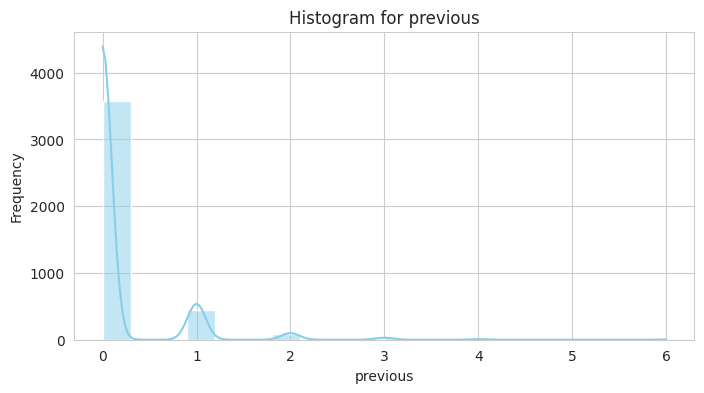

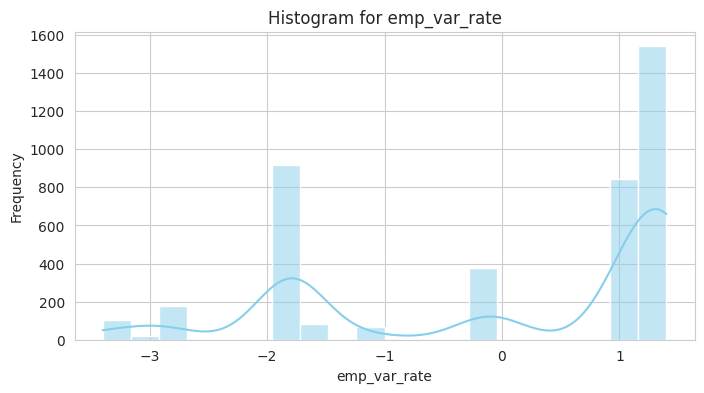

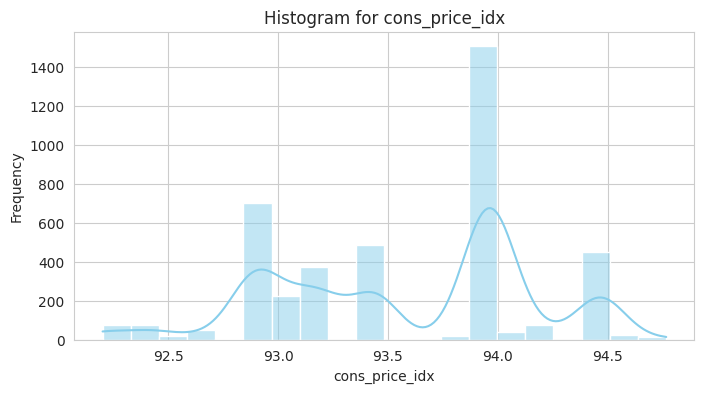

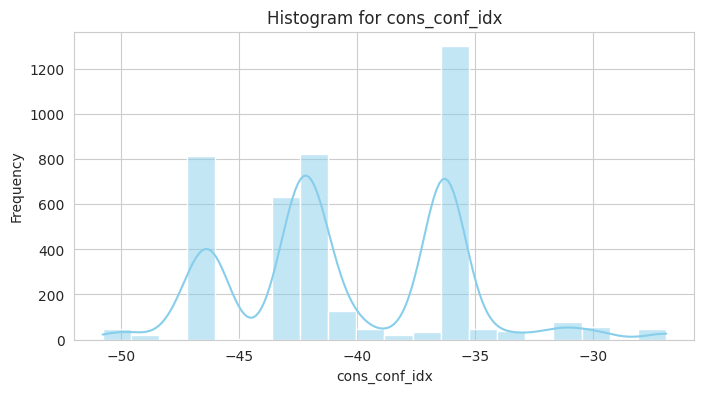

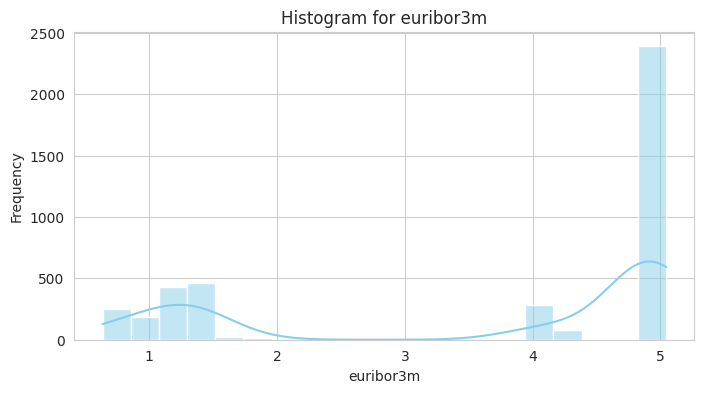

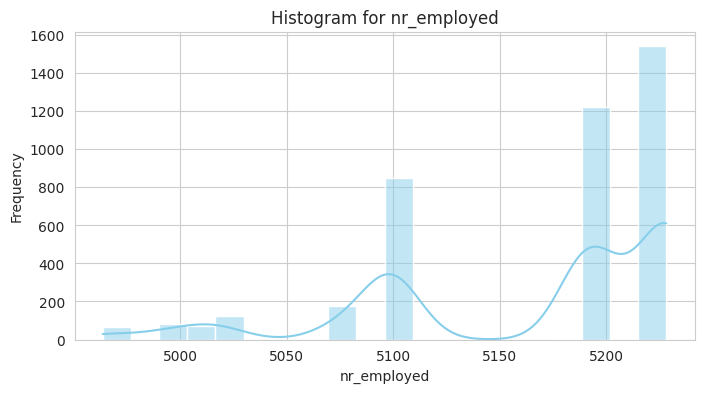

In [0]:
# Convert the PySpark DataFrame to a Pandas DataFrame
sample_pd_df = sample_df.toPandas()
# Set a custom color palette for seaborn
sns.set_palette("Set2")

# Customize style for seaborn
sns.set_style("whitegrid")

# Display the first 5 rows of the Pandas DataFrame
print("First 5 rows of the Pandas DataFrame:")
print(sample_pd_df.head())

# Summary statistics
print("\nSummary Statistics:")
print(sample_pd_df.describe())

# Data types of columns
print("\nData Types:")
print(sample_pd_df.dtypes)

# Count missing values
print("\nMissing Values:")
print(sample_pd_df.isnull().sum())

# Value counts for categorical columns
print("\nValue Counts for Categorical Columns:")
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=sample_pd_df, x=col, palette="Set2")
    plt.title(f'Value Counts for {col}')
    plt.xlabel(col)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')
    plt.show()

# Histogram for numeric columns
numeric_columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=sample_pd_df, x=col, bins=20, kde=True, color="skyblue")
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [0]:
from pyspark.sql.functions import col, when

# Impute missing values for categorical columns with the mode
for column in categorical_columns:
    mode = df.groupBy(column).count().orderBy('count', ascending=False).first()[0]
    df = df.na.fill({column: mode})


# Function to calculate lower and upper bounds for outlier capping based on IQR
def cap_outliers(df, col_name):
    # Calculate Q1 and Q3 and subsequently IQR
    quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.05)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1
    
    # Calculate bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Capping outliers
    df = df.withColumn(col_name, 
                       when(col(col_name) < lower_bound, lower_bound)
                       .when(col(col_name) > upper_bound, upper_bound)
                       .otherwise(col(col_name)))
    return df

# Apply outlier capping to numeric columns
numeric_columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 'euribor3m']
for col_name in numeric_columns:
    df = cap_outliers(df, col_name)

# For numeric columns, replace nulls with the mean
for column in numeric_columns:
    mean_value = df.select(_mean(col(column)).alias('mean')).collect()[0]['mean']
    df = df.na.fill({column: mean_value})

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Example: Transform a categorical column using StringIndexer
string_indexer = StringIndexer(inputCol='marital', outputCol='marital_indexed')
df = string_indexer.fit(df).transform(df)

# Example: Apply OneHotEncoder to indexed categorical columns
encoder = OneHotEncoder(inputCols=['marital_indexed'], outputCols=['marital_encoded'])
model = encoder.fit(df)
df = model.transform(df)

In [0]:
# Example: Split the data into 80% training and 20% testing
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


In [0]:
# Example: Oversampling the minority class
from pyspark.sql.functions import col

minority_class = train_df.filter(col('y') == 'yes')
majority_class = train_df.filter(col('y') == 'no')

oversampled_minority = minority_class.sample(fraction=1.0, seed=42)
balanced_train_df = majority_class.union(oversampled_minority)


Combined Modeling and Hyperparameter Tuning

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

# Define the categorical columns
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
                       'month', 'day_of_week', 'poutcome']

# Apply StringIndexer to categorical columns, only if the indexed column doesn't already exist
indexers = []
for column in categorical_columns:
    indexed_column = column + "_indexed"
    if indexed_column not in balanced_train_df.columns:
        indexer = StringIndexer(inputCol=column, outputCol=indexed_column)
        indexers.append(indexer)

indexer_pipeline = Pipeline(stages=indexers)
indexed_train_df = indexer_pipeline.fit(balanced_train_df).transform(balanced_train_df)

# Update the feature_columns list to include the indexed columns
feature_columns = ['age', 'job_indexed', 'marital_indexed', 'education_indexed', 'default_indexed',
                   'housing_indexed', 'loan_indexed', 'contact_indexed', 'month_indexed',
                   'day_of_week_indexed', 'duration', 'campaign', 'pdays', 'previous',
                   'poutcome_indexed', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx',
                   'euribor3m', 'nr_employed']

# Create a VectorAssembler to combine the feature columns into a single "features" column
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Transform the data by applying the VectorAssembler
indexed_train_df = assembler.transform(indexed_train_df)

# Define the label column
label_column = 'y'
label_indexer = StringIndexer(inputCol=label_column, outputCol='label')
indexed_train_df = label_indexer.fit(indexed_train_df).transform(indexed_train_df)

# Define the Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label')

# Define the Random Forest model
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

# Define parameter grids for both models
param_grid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.2]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

param_grid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.numTrees, [20, 50]) \
    .build()

# Define an evaluator for model evaluation
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC')

# Create cross-validators for both models
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=param_grid_lr, evaluator=evaluator, numFolds=5)
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=param_grid_rf, evaluator=evaluator, numFolds=5)

# Fit cross-validators on the training data
cv_model_lr = cv_lr.fit(indexed_train_df)
cv_model_rf = cv_rf.fit(indexed_train_df)

# Get the best models for both LR and RF
best_lr_model = cv_model_lr.bestModel
best_rf_model = cv_model_rf.bestModel



In [0]:
# Apply the same preprocessing steps to test_df as you did for the training data

# Apply StringIndexer to categorical columns in test_df
for column in categorical_columns:
    indexed_column = column + "_indexed"
    if indexed_column not in test_df.columns:
        indexer = StringIndexer(inputCol=column, outputCol=indexed_column)
        test_df = indexer.fit(test_df).transform(test_df)

# Create a VectorAssembler to combine the feature columns into a single "features" column for test_df
test_df = assembler.transform(test_df)

# Apply StringIndexer to label column in test_df
test_df = label_indexer.fit(test_df).transform(test_df)

# Evaluate the best LR model on the test data
test_predictions_lr = best_lr_model.transform(test_df)
auc_lr = evaluator.evaluate(test_predictions_lr)

# Evaluate the best RF model on the test data
test_predictions_rf = best_rf_model.transform(test_df)
auc_rf = evaluator.evaluate(test_predictions_rf)

# Print AUC for both models
print("AUC of Best Logistic Regression Model:", auc_lr)
print("AUC of Best Random Forest Model:", auc_rf)


AUC of Best Logistic Regression Model: 0.9211205116063722
AUC of Best Random Forest Model: 0.9410475963099202


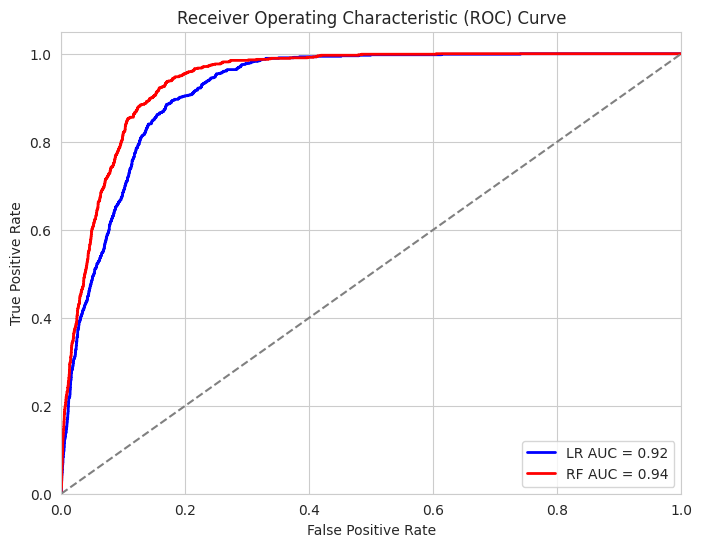

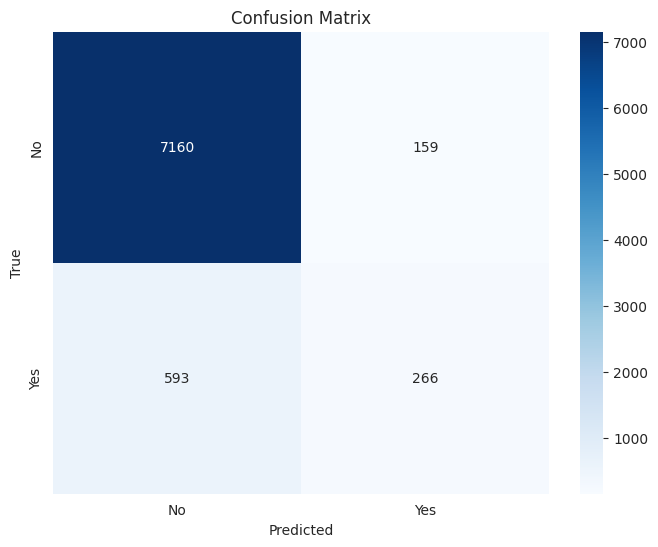

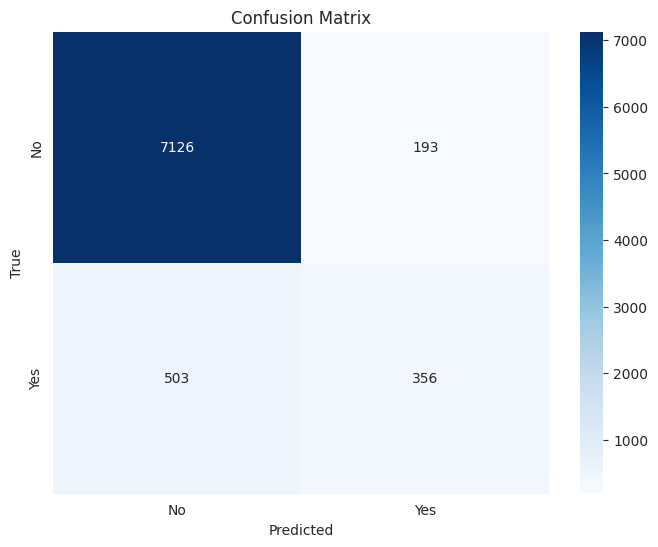

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns

# Get predicted probabilities for positive class (class 1) for both models
probs_lr = np.array(test_predictions_lr.select('probability').rdd.map(lambda x: x[0][1]).collect())
probs_rf = np.array(test_predictions_rf.select('probability').rdd.map(lambda x: x[0][1]).collect())

# Calculate ROC curve and AUC for both models
fpr_lr, tpr_lr, _ = roc_curve(test_df.select('label').rdd.map(lambda x: x[0]).collect(), probs_lr)
fpr_rf, tpr_rf, _ = roc_curve(test_df.select('label').rdd.map(lambda x: x[0]).collect(), probs_rf)
roc_auc_lr = roc_auc_score(test_df.select('label').rdd.map(lambda x: x[0]).collect(), probs_lr)
roc_auc_rf = roc_auc_score(test_df.select('label').rdd.map(lambda x: x[0]).collect(), probs_rf)

# Create ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'LR AUC = {roc_auc_lr:.2f}')
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label=f'RF AUC = {roc_auc_rf:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Create confusion matrices for both models
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

labels = ['No', 'Yes']
cm_lr = confusion_matrix(test_df.select('label').rdd.map(lambda x: x[0]).collect(), (probs_lr > 0.5).astype(int))
cm_rf = confusion_matrix(test_df.select('label').rdd.map(lambda x: x[0]).collect(), (probs_rf > 0.5).astype(int))

# Plot confusion matrices
plot_confusion_matrix(cm_lr, labels)
plot_confusion_matrix(cm_rf, labels)
